In [1]:
!pip install opencv-python
!pip install torchmetrics
!pip install torchsummary

import torch
import random
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from PIL import Image
from torchmetrics import Accuracy, Precision, Recall, F1Score
import pytorch_lightning as pl
from torchsummary import summary
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch import nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
import torchmetrics

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

clear_output()

In [2]:
# Set random seed for PyTorch
torch.manual_seed(42)
# Set random seed for CUDA (GPU computations)
torch.cuda.manual_seed(42)
# Set random seed for NumPy operations on CPU
np.random.seed(42)
# Set random seed for Python's random module
random.seed(42)

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [4]:
image_path = "/kaggle/input/crop-diseases-classification/Data/train_images"
image_list = os.listdir(image_path)
df = pd.read_csv("/kaggle/input/crop-diseases-classification/Data/train.csv")

df.shape, len(image_list) 
# 17938 image varken train.csv 21397 veri içeriyor image idlere göre filtreleyeceğiz
# Filtreleme işlemi
df = df[df["image_id"].isin(image_list)]
df.reset_index(drop=True, inplace=True)
df.shape
#Json dosyasındaki label numaralarına göre isimleri içeri aktaralım
with open("/kaggle/input/crop-diseases-classification/Data/label_num_to_disease_map.json", "r") as file:
    label_name = json.load(file)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [5]:
data_transform = transforms.Compose([
    transforms.Resize(size=(227, 227)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomResizedCrop(227),
    transforms.RandomRotation(degrees=15),

    #transforms.RandomGrayscale(p=0.1),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

test_transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])


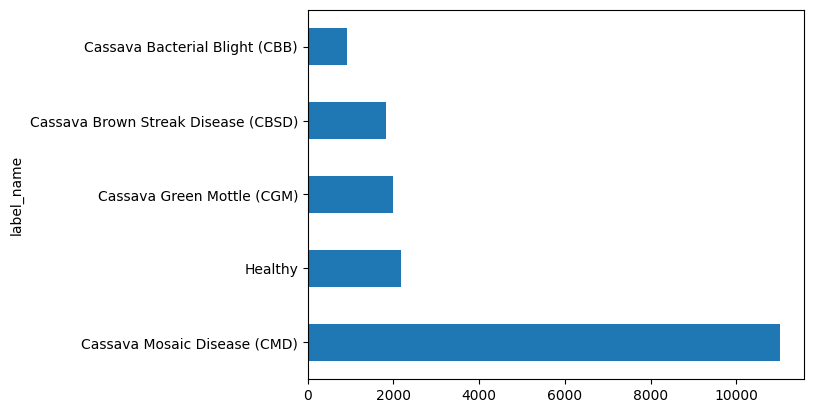

In [6]:
df['label_name'] = df['label'].astype(str).map(label_name)
df
df['label_name'].value_counts().plot(kind='barh')
plt.show()

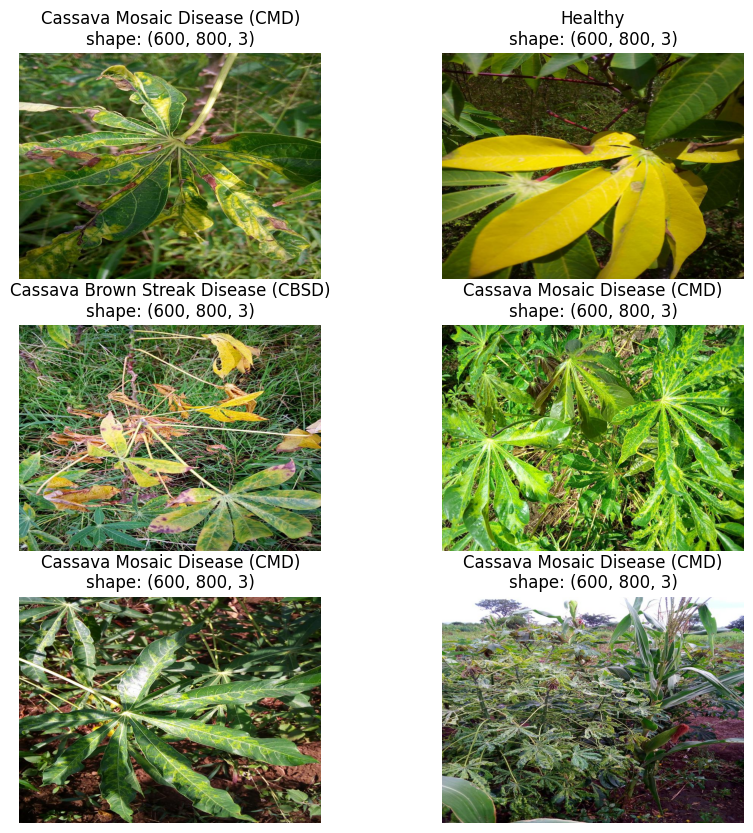

In [7]:
# Sample alalım label numaralarına göre isimlerini aldığımız image'ları görüntüleyelim
sample = df.sample(6)
plt.figure(figsize=(10, 10))
j = 0
for i, row in sample.iterrows():
    path = image_path + "/" + row['image_id']  
    plt.subplot(3,2,j+1)
    j += 1
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    img_shape = np.asarray(img)
    plt.title(label_name[str(row['label'])] + f"\nshape: {img_shape.shape}")
j = 0
plt.show()

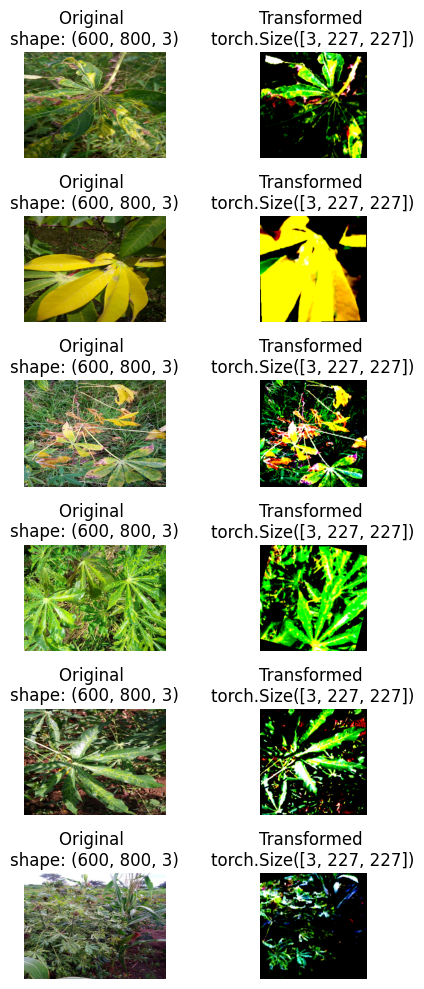

In [8]:

plt.figure(figsize=(5, 10))
j = 0
for i, row in sample.iterrows():
    path = image_path + "/"+ row['image_id']
    plt.subplot(6, 2, j+1)
    j += 1
    img = Image.open(path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Original \nshape: {img_shape.shape}")
    plt.subplot(6, 2, j+1)
    j += 1
    img_transformed = data_transform(img)
    plt.imshow(img_transformed.permute(1, 2, 0))  # Tensor formatını RGB formatına dönüştürme
    plt.axis('off')
    plt.title(f'Transformed \n{img_transformed.shape}')
plt.tight_layout()
plt.show()

In [9]:
import shutil

def create_folders(df, train_ratio=0.9):
    
    for label_name in df['label_name'].unique():
        train_folder_path = os.path.join('/kaggle/working/train', label_name)
        test_folder_path = os.path.join('/kaggle/working/test', label_name)
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)

        
    
        label_df = df[df['label_name'] == label_name]
        train_size = int(len(label_df) * train_ratio)
        train_df = label_df.sample(n=train_size)
        test_df = label_df.drop(train_df.index)

        
        copy_images(train_df, train_folder_path)
        copy_images(test_df, test_folder_path)


def copy_images(df, destination_path):
    for index, row in df.iterrows():
        source_path = os.path.join('/kaggle/input/crop-diseases-classification/Data/train_images', row['image_id'])
        destination_file_path = os.path.join(destination_path, row['image_id'])
        shutil.copy(source_path, destination_file_path)


create_folders(df)

import os


def count_files_in_folder(folder_path):
    return len(os.listdir(folder_path))


train_folder = '/kaggle/working/train'
test_folder = '/kaggle/working/test'

for label_name in os.listdir(train_folder):
    train_label_path = os.path.join(train_folder, label_name)
    test_label_path = os.path.join(test_folder, label_name)

    train_count = count_files_in_folder(train_label_path)
    test_count = count_files_in_folder(test_label_path)

    print(f"Label '{label_name}' için eğitim veri sayısı: {train_count}")
    print(f"Label '{label_name}' için test veri sayısı: {test_count}")

image_path = "/kaggle/working/"
train_dir = "/kaggle/working/train"
test_dir = "/kaggle/working/test"
target_directory = train_dir
print(f"Target directory: {target_directory}")

class_names_found = sorted([entry.name for entry in os.scandir(os.path.join(image_path, "train"))])
print(f"Class names found: {class_names_found}")

from typing import List, Dict, Tuple


def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
    return classes, class_to_idx

Label 'Cassava Bacterial Blight (CBB)' için eğitim veri sayısı: 828
Label 'Cassava Bacterial Blight (CBB)' için test veri sayısı: 93
Label 'Cassava Brown Streak Disease (CBSD)' için eğitim veri sayısı: 1647
Label 'Cassava Brown Streak Disease (CBSD)' için test veri sayısı: 184
Label 'Cassava Green Mottle (CGM)' için eğitim veri sayısı: 1793
Label 'Cassava Green Mottle (CGM)' için test veri sayısı: 200
Label 'Cassava Mosaic Disease (CMD)' için eğitim veri sayısı: 9924
Label 'Cassava Mosaic Disease (CMD)' için test veri sayısı: 1103
Label 'Healthy' için eğitim veri sayısı: 1949
Label 'Healthy' için test veri sayısı: 217
Target directory: /kaggle/working/train
Class names found: ['Cassava Bacterial Blight (CBB)', 'Cassava Brown Streak Disease (CBSD)', 'Cassava Green Mottle (CGM)', 'Cassava Mosaic Disease (CMD)', 'Healthy']


In [10]:
from torch.utils.data import Dataset
from pathlib import Path
import pathlib
import random


class ImageFolderCustom(Dataset):

    def __init__(self, targ_dir: str, transform=None, num_samples_to_remove=0) -> None:

        self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) 
     
        self.transform = transform
        
        self.classes, self.class_to_idx = find_classes(targ_dir)

        self.samples_to_remove = []
        if num_samples_to_remove > 0:
            label_3_indices = [idx for idx, path in enumerate(self.paths) if path.parent.name == 'Cassava Mosaic Disease (CMD)']
            self.samples_to_remove = random.sample(label_3_indices, num_samples_to_remove)
            self.paths = [path for idx, path in enumerate(self.paths) if idx not in self.samples_to_remove]

    
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path)

    
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)

    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        
        if self.transform:
            return self.transform(img), class_idx 
        else:
            return img, class_idx # return data, label (X, y)

In [11]:

train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=data_transform,
                                      num_samples_to_remove = 0)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transform,
                                    num_samples_to_remove= 0)
train_data_custom, test_data_custom, len(train_data_custom), len(test_data_custom)


(<__main__.ImageFolderCustom at 0x7e58a0fbcdf0>,
 16141,
 1797)

In [12]:
def cutout(img, n_holes=1, length=16):
    h, w = img.size(2), img.size(3)  # Get the height and width dimensions

    mask = torch.ones_like(img)  # Create a mask tensor with the same shape as the image tensor

    for _ in range(n_holes):
        y = np.random.randint(h)
        x = np.random.randint(w)

        y1 = np.clip(y - length // 2, 0, h)
        y2 = np.clip(y + length // 2, 0, h)
        x1 = np.clip(x - length // 2, 0, w)
        x2 = np.clip(x + length // 2, 0, w)

        mask[:, :, y1:y2, x1:x2] = 0.0  # Update the mask tensor for each batch item

    return img * mask  # Apply the mask to the image tensor

def cutmix(img1, img2, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = img1.size()
    bbx1, bby1, bbx2, bby2 = rand_bbox((h, w), lam)
    img1[:, :, bbx1:bbx2, bby1:bby2] = img2[:, :, bbx1:bbx2, bby1:bby2]
    return img1, lam

def rand_bbox(size, lam):
    W, H = size
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


In [13]:

TRAIN_BATCH_SIZE = 64
TEST_BATCH_SIZE = 16
NUM_WORKERS = 2
from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset=train_data_custom, 
                                     batch_size=TRAIN_BATCH_SIZE, 
                                     num_workers=NUM_WORKERS, 
                                     shuffle=True) 

test_dataloader_custom = DataLoader(dataset=test_data_custom, 
                                    batch_size=TEST_BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False) 

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e58a0f62ec0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e58a1125bd0>)

In [14]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()

    loss_metric = nn.CrossEntropyLoss()
    accuracy_metric = Accuracy(num_classes=5, task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro', task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro', task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro', task='multiclass').to(device)

    total_loss = 0
    with torch.enable_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Randomly choose between cutout and cutmix for each batch
            if random.random() < 0.5:
                X, lam = cutmix(X, X[torch.randperm(X.size(0))])
            #X = cutout(X)  # Apply cutout
            #else:
                 

            y_pred = model(X)
            loss = loss_metric(y_pred, y)
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy_metric.update(y_pred_class, y)
            precision_metric.update(y_pred_class, y)
            recall_metric.update(y_pred_class, y)
            f1_metric.update(y_pred_class, y)

    total_loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    return total_loss, accuracy, precision, recall, f1

In [15]:


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    model.eval()

    loss_metric = loss_fn
    accuracy_metric = Accuracy(num_classes=5,task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro',task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro',task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro',task='multiclass').to(device)

    total_loss = 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)
            loss = loss_metric(test_pred_logits, y)
            total_loss += loss.item()

            test_pred_labels = test_pred_logits.argmax(dim=1)
            accuracy_metric.update(test_pred_labels, y)
            precision_metric.update(test_pred_labels, y)
            recall_metric.update(test_pred_labels, y)
            f1_metric.update(test_pred_labels, y)

    total_loss /= len(dataloader)
    accuracy = accuracy_metric.compute()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    f1 = f1_metric.compute()

    return total_loss, accuracy, precision, recall, f1

In [16]:
def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          scheduler: torch.optim.lr_scheduler,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")):

    model.to(device)

    loss_metric = loss_fn
    accuracy_metric = Accuracy(num_classes=5, task='multiclass').to(device)
    precision_metric = Precision(num_classes=5, average='macro', task='multiclass').to(device)
    recall_metric = Recall(num_classes=5, average='macro', task='multiclass').to(device)
    f1_metric = F1Score(num_classes=5, average='macro', task='multiclass').to(device)

    results = {"train_loss": [], "train_acc": [], "train_precision": [], "train_recall": [], "train_f1": [],
               "test_loss": [], "test_acc": [], "test_precision": [], "test_recall": [], "test_f1": []}

    for epoch in tqdm(range(epochs), desc="Training"):
        train_loss, train_acc, train_precision, train_recall, train_f1 = train_step(model=model,
                                                                                    dataloader=train_dataloader,
                                                                                    loss_fn=loss_metric,
                                                                                    optimizer=optimizer,
                                                                                    device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1 = test_step(model=model,
                                                                              dataloader=test_dataloader,
                                                                              loss_fn=loss_metric,
                                                                              device=device)

        scheduler.step(test_loss)  # Pass the validation loss to scheduler.step()

        print(f"Epoch: {epoch+1} | "
              f"train_loss: {train_loss:.4f} | "
              f"train_acc: {train_acc:.4f} | "
              f"train_precision: {train_precision:.4f} | "
              f"train_recall: {train_recall:.4f} | "
              f"train_f1: {train_f1:.4f} | "
              f"test_loss: {test_loss:.4f} | "
              f"test_acc: {test_acc:.4f} | "
              f"test_precision: {test_precision:.4f} | "
              f"test_recall: {test_recall:.4f} | "
              f"test_f1: {test_f1:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)

    return results


In [17]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class BottleneckBlock(nn.Module):
    expansion = 4
    
    def __init__(self, in_channels, intermediate_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, intermediate_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(intermediate_channels)
        self.conv2 = nn.Conv2d(intermediate_channels, intermediate_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(intermediate_channels)
        self.conv3 = nn.Conv2d(intermediate_channels, intermediate_channels * self.expansion, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(intermediate_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = None
        if stride != 1 or in_channels != intermediate_channels * self.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, intermediate_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(intermediate_channels * self.expansion)
            )

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, intermediate_channels, num_blocks, stride=1):
        layers = []
        layers.append(block(self.in_channels, intermediate_channels, stride))
        self.in_channels = intermediate_channels * block.expansion
        for _ in range(1, num_blocks):
            layers.append(block(self.in_channels, intermediate_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# ResNet-18
def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# ResNet-34
def ResNet34(num_classes=10):
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes)

# ResNet-50
def ResNet50(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 6, 3], num_classes)

# ResNet-101
def ResNet101(num_classes=10):
    return ResNet(BottleneckBlock, [3, 4, 23, 3], num_classes)

# ResNet-152
def ResNet152(num_classes=10):
    return ResNet(BottleneckBlock, [3, 8, 36, 3], num_classes)


model_18 = ResNet18(num_classes=5)
model_34 = ResNet34(num_classes=5)
model_50 = ResNet50(num_classes=5)
model_101 = ResNet101(num_classes=5)
model_152 = ResNet152(num_classes=5)




In [18]:
# VGGNet Modeli
model = model_34.to(device)

# EfficientNet-B4 modeli
#model = timm.create_model('efficientnet_b4', pretrained=True)
#model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=5)


In [19]:
import timm
import torch.optim as optim
from tqdm import tqdm
from torch import nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from torch.nn.parallel import DataParallel


model.to(device)
if torch.cuda.device_count() > 1:
    model = DataParallel(model)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

results = train(model=model,
                train_dataloader=train_dataloader_custom,
                test_dataloader=test_dataloader_custom,
                optimizer=optimizer,
                scheduler=scheduler,
                loss_fn=nn.CrossEntropyLoss(),
                epochs=40,
                device=device)


Training:   2%|▎         | 1/40 [01:40<1:05:01, 100.05s/it]

Epoch: 1 | train_loss: 1.1157 | train_acc: 0.6149 | train_precision: 0.3141 | train_recall: 0.2338 | train_f1: 0.2191 | test_loss: 1.1398 | test_acc: 0.6171 | test_precision: 0.2652 | test_recall: 0.2160 | test_f1: 0.1826


Training:   5%|▌         | 2/40 [03:16<1:02:00, 97.91s/it] 

Epoch: 2 | train_loss: 1.0455 | train_acc: 0.6269 | train_precision: 0.3245 | train_recall: 0.2634 | train_f1: 0.2575 | test_loss: 1.0525 | test_acc: 0.6216 | test_precision: 0.4901 | test_recall: 0.2231 | test_f1: 0.1957


Training:   8%|▊         | 3/40 [04:53<1:00:13, 97.67s/it]

Epoch: 3 | train_loss: 1.0020 | train_acc: 0.6394 | train_precision: 0.4124 | train_recall: 0.2944 | train_f1: 0.2989 | test_loss: 1.0107 | test_acc: 0.6522 | test_precision: 0.3627 | test_recall: 0.3738 | test_f1: 0.3657


Training:  10%|█         | 4/40 [06:29<58:09, 96.93s/it]  

Epoch: 4 | train_loss: 0.9561 | train_acc: 0.6498 | train_precision: 0.4272 | train_recall: 0.3240 | train_f1: 0.3371 | test_loss: 0.8719 | test_acc: 0.6795 | test_precision: 0.5037 | test_recall: 0.3859 | test_f1: 0.3974


Training:  12%|█▎        | 5/40 [08:05<56:23, 96.66s/it]

Epoch: 5 | train_loss: 0.9329 | train_acc: 0.6565 | train_precision: 0.4475 | train_recall: 0.3433 | train_f1: 0.3640 | test_loss: 0.9456 | test_acc: 0.6733 | test_precision: 0.4807 | test_recall: 0.4219 | test_f1: 0.4428


Training:  15%|█▌        | 6/40 [09:44<55:06, 97.24s/it]

Epoch: 6 | train_loss: 0.9047 | train_acc: 0.6633 | train_precision: 0.4588 | train_recall: 0.3633 | train_f1: 0.3850 | test_loss: 0.8792 | test_acc: 0.6795 | test_precision: 0.5453 | test_recall: 0.4776 | test_f1: 0.4459


Training:  18%|█▊        | 7/40 [11:19<53:12, 96.75s/it]

Epoch: 7 | train_loss: 0.8889 | train_acc: 0.6707 | train_precision: 0.4715 | train_recall: 0.3726 | train_f1: 0.3965 | test_loss: 0.8427 | test_acc: 0.7001 | test_precision: 0.5631 | test_recall: 0.4242 | test_f1: 0.4482


Training:  20%|██        | 8/40 [12:56<51:36, 96.76s/it]

Epoch: 8 | train_loss: 0.8728 | train_acc: 0.6772 | train_precision: 0.4898 | train_recall: 0.3941 | train_f1: 0.4197 | test_loss: 1.1623 | test_acc: 0.5237 | test_precision: 0.4782 | test_recall: 0.4286 | test_f1: 0.3949


Training:  22%|██▎       | 9/40 [14:35<50:19, 97.41s/it]

Epoch: 9 | train_loss: 0.8671 | train_acc: 0.6811 | train_precision: 0.5008 | train_recall: 0.4042 | train_f1: 0.4319 | test_loss: 0.8094 | test_acc: 0.7090 | test_precision: 0.6192 | test_recall: 0.4603 | test_f1: 0.4628


Training:  25%|██▌       | 10/40 [16:11<48:27, 96.91s/it]

Epoch: 10 | train_loss: 0.8324 | train_acc: 0.6957 | train_precision: 0.5269 | train_recall: 0.4335 | train_f1: 0.4628 | test_loss: 0.7425 | test_acc: 0.7446 | test_precision: 0.6091 | test_recall: 0.5439 | test_f1: 0.5668


Training:  28%|██▊       | 11/40 [17:47<46:47, 96.82s/it]

Epoch: 11 | train_loss: 0.8274 | train_acc: 0.6990 | train_precision: 0.5302 | train_recall: 0.4365 | train_f1: 0.4661 | test_loss: 0.7582 | test_acc: 0.7145 | test_precision: 0.5585 | test_recall: 0.4504 | test_f1: 0.4722


Training:  30%|███       | 12/40 [19:24<45:10, 96.80s/it]

Epoch: 12 | train_loss: 0.8104 | train_acc: 0.7037 | train_precision: 0.5352 | train_recall: 0.4475 | train_f1: 0.4766 | test_loss: 0.7828 | test_acc: 0.7090 | test_precision: 0.5760 | test_recall: 0.4638 | test_f1: 0.4932


Training:  32%|███▎      | 13/40 [21:02<43:39, 97.03s/it]

Epoch: 13 | train_loss: 0.8347 | train_acc: 0.6945 | train_precision: 0.5258 | train_recall: 0.4287 | train_f1: 0.4589 | test_loss: 0.8184 | test_acc: 0.7001 | test_precision: 0.5890 | test_recall: 0.4303 | test_f1: 0.4302


Training:  35%|███▌      | 14/40 [22:40<42:09, 97.27s/it]

Epoch: 14 | train_loss: 0.8072 | train_acc: 0.7071 | train_precision: 0.5499 | train_recall: 0.4534 | train_f1: 0.4854 | test_loss: 0.7606 | test_acc: 0.7307 | test_precision: 0.5903 | test_recall: 0.5002 | test_f1: 0.5222


Training:  38%|███▊      | 15/40 [24:16<40:27, 97.10s/it]

Epoch: 15 | train_loss: 0.7912 | train_acc: 0.7106 | train_precision: 0.5528 | train_recall: 0.4622 | train_f1: 0.4927 | test_loss: 0.7771 | test_acc: 0.7257 | test_precision: 0.5912 | test_recall: 0.5589 | test_f1: 0.5505


Training:  40%|████      | 16/40 [25:55<39:00, 97.54s/it]

Epoch 00016: reducing learning rate of group 0 to 1.0000e-05.
Epoch: 16 | train_loss: 0.8026 | train_acc: 0.7071 | train_precision: 0.5525 | train_recall: 0.4569 | train_f1: 0.4889 | test_loss: 0.7439 | test_acc: 0.7223 | test_precision: 0.5830 | test_recall: 0.4978 | test_f1: 0.5130


Training:  42%|████▎     | 17/40 [27:33<37:25, 97.63s/it]

Epoch: 17 | train_loss: 0.7508 | train_acc: 0.7286 | train_precision: 0.5853 | train_recall: 0.4922 | train_f1: 0.5251 | test_loss: 0.6705 | test_acc: 0.7618 | test_precision: 0.6314 | test_recall: 0.5914 | test_f1: 0.6063


Training:  45%|████▌     | 18/40 [29:12<35:55, 98.00s/it]

Epoch: 18 | train_loss: 0.7389 | train_acc: 0.7340 | train_precision: 0.5907 | train_recall: 0.5008 | train_f1: 0.5328 | test_loss: 0.6575 | test_acc: 0.7679 | test_precision: 0.6370 | test_recall: 0.6043 | test_f1: 0.6171


Training:  48%|████▊     | 19/40 [30:50<34:22, 98.23s/it]

Epoch: 19 | train_loss: 0.7356 | train_acc: 0.7360 | train_precision: 0.5946 | train_recall: 0.5065 | train_f1: 0.5384 | test_loss: 0.6609 | test_acc: 0.7602 | test_precision: 0.6201 | test_recall: 0.5929 | test_f1: 0.5996


Training:  50%|█████     | 20/40 [32:28<32:43, 98.17s/it]

Epoch: 20 | train_loss: 0.7267 | train_acc: 0.7393 | train_precision: 0.6006 | train_recall: 0.5153 | train_f1: 0.5472 | test_loss: 0.6570 | test_acc: 0.7607 | test_precision: 0.6202 | test_recall: 0.5682 | test_f1: 0.5806


Training:  52%|█████▎    | 21/40 [34:05<30:55, 97.66s/it]

Epoch: 21 | train_loss: 0.7357 | train_acc: 0.7350 | train_precision: 0.5942 | train_recall: 0.5077 | train_f1: 0.5399 | test_loss: 0.6608 | test_acc: 0.7590 | test_precision: 0.6251 | test_recall: 0.5943 | test_f1: 0.6068


Training:  55%|█████▌    | 22/40 [35:41<29:11, 97.28s/it]

Epoch: 22 | train_loss: 0.7068 | train_acc: 0.7469 | train_precision: 0.6092 | train_recall: 0.5305 | train_f1: 0.5603 | test_loss: 0.6421 | test_acc: 0.7657 | test_precision: 0.6381 | test_recall: 0.5909 | test_f1: 0.6078


Training:  57%|█████▊    | 23/40 [37:20<27:38, 97.58s/it]

Epoch: 23 | train_loss: 0.7195 | train_acc: 0.7412 | train_precision: 0.6021 | train_recall: 0.5187 | train_f1: 0.5498 | test_loss: 0.6345 | test_acc: 0.7735 | test_precision: 0.6471 | test_recall: 0.6096 | test_f1: 0.6253


Training:  60%|██████    | 24/40 [38:57<26:02, 97.64s/it]

Epoch: 24 | train_loss: 0.7297 | train_acc: 0.7373 | train_precision: 0.6010 | train_recall: 0.5175 | train_f1: 0.5494 | test_loss: 0.6466 | test_acc: 0.7713 | test_precision: 0.6559 | test_recall: 0.5810 | test_f1: 0.6077


Training:  62%|██████▎   | 25/40 [40:35<24:24, 97.64s/it]

Epoch: 25 | train_loss: 0.7042 | train_acc: 0.7440 | train_precision: 0.6094 | train_recall: 0.5264 | train_f1: 0.5578 | test_loss: 0.6385 | test_acc: 0.7724 | test_precision: 0.6465 | test_recall: 0.6180 | test_f1: 0.6282


Training:  65%|██████▌   | 26/40 [42:14<22:53, 98.10s/it]

Epoch: 26 | train_loss: 0.6977 | train_acc: 0.7509 | train_precision: 0.6144 | train_recall: 0.5357 | train_f1: 0.5659 | test_loss: 0.6531 | test_acc: 0.7702 | test_precision: 0.6621 | test_recall: 0.5934 | test_f1: 0.6149


Training:  68%|██████▊   | 27/40 [43:54<21:23, 98.69s/it]

Epoch: 27 | train_loss: 0.6890 | train_acc: 0.7516 | train_precision: 0.6169 | train_recall: 0.5377 | train_f1: 0.5681 | test_loss: 0.6330 | test_acc: 0.7718 | test_precision: 0.6503 | test_recall: 0.6179 | test_f1: 0.6314


Training:  70%|███████   | 28/40 [45:31<19:37, 98.13s/it]

Epoch: 28 | train_loss: 0.6975 | train_acc: 0.7508 | train_precision: 0.6177 | train_recall: 0.5417 | train_f1: 0.5716 | test_loss: 0.6403 | test_acc: 0.7735 | test_precision: 0.6616 | test_recall: 0.6092 | test_f1: 0.6237


Training:  72%|███████▎  | 29/40 [47:09<17:57, 97.96s/it]

Epoch: 29 | train_loss: 0.7303 | train_acc: 0.7375 | train_precision: 0.6007 | train_recall: 0.5138 | train_f1: 0.5456 | test_loss: 0.6457 | test_acc: 0.7685 | test_precision: 0.6509 | test_recall: 0.5873 | test_f1: 0.6112


Training:  75%|███████▌  | 30/40 [48:48<16:23, 98.37s/it]

Epoch: 30 | train_loss: 0.7053 | train_acc: 0.7467 | train_precision: 0.6167 | train_recall: 0.5369 | train_f1: 0.5672 | test_loss: 0.6487 | test_acc: 0.7713 | test_precision: 0.6441 | test_recall: 0.6196 | test_f1: 0.6281


Training:  78%|███████▊  | 31/40 [50:27<14:47, 98.60s/it]

Epoch: 31 | train_loss: 0.6993 | train_acc: 0.7457 | train_precision: 0.6088 | train_recall: 0.5303 | train_f1: 0.5610 | test_loss: 0.6387 | test_acc: 0.7730 | test_precision: 0.6550 | test_recall: 0.6323 | test_f1: 0.6381


Training:  80%|████████  | 32/40 [52:05<13:06, 98.31s/it]

Epoch: 32 | train_loss: 0.6817 | train_acc: 0.7547 | train_precision: 0.6240 | train_recall: 0.5432 | train_f1: 0.5750 | test_loss: 0.6318 | test_acc: 0.7769 | test_precision: 0.6561 | test_recall: 0.6227 | test_f1: 0.6322


Training:  82%|████████▎ | 33/40 [53:43<11:27, 98.19s/it]

Epoch: 33 | train_loss: 0.6809 | train_acc: 0.7560 | train_precision: 0.6252 | train_recall: 0.5499 | train_f1: 0.5796 | test_loss: 0.6543 | test_acc: 0.7702 | test_precision: 0.6536 | test_recall: 0.6246 | test_f1: 0.6316


Training:  85%|████████▌ | 34/40 [55:21<09:49, 98.22s/it]

Epoch: 34 | train_loss: 0.6927 | train_acc: 0.7519 | train_precision: 0.6191 | train_recall: 0.5410 | train_f1: 0.5714 | test_loss: 0.6604 | test_acc: 0.7646 | test_precision: 0.6493 | test_recall: 0.6210 | test_f1: 0.6253


Training:  88%|████████▊ | 35/40 [56:58<08:09, 97.84s/it]

Epoch: 35 | train_loss: 0.6711 | train_acc: 0.7612 | train_precision: 0.6307 | train_recall: 0.5555 | train_f1: 0.5853 | test_loss: 0.6403 | test_acc: 0.7657 | test_precision: 0.6496 | test_recall: 0.5757 | test_f1: 0.5815


Training:  90%|█████████ | 36/40 [58:35<06:30, 97.54s/it]

Epoch: 36 | train_loss: 0.6878 | train_acc: 0.7553 | train_precision: 0.6290 | train_recall: 0.5498 | train_f1: 0.5806 | test_loss: 0.6595 | test_acc: 0.7557 | test_precision: 0.6450 | test_recall: 0.6034 | test_f1: 0.6104


Training:  92%|█████████▎| 37/40 [1:00:11<04:51, 97.30s/it]

Epoch: 37 | train_loss: 0.6993 | train_acc: 0.7540 | train_precision: 0.6216 | train_recall: 0.5411 | train_f1: 0.5724 | test_loss: 0.6504 | test_acc: 0.7679 | test_precision: 0.6424 | test_recall: 0.5993 | test_f1: 0.6168


Training:  95%|█████████▌| 38/40 [1:01:49<03:14, 97.40s/it]

Epoch 00038: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 38 | train_loss: 0.7030 | train_acc: 0.7465 | train_precision: 0.6156 | train_recall: 0.5313 | train_f1: 0.5636 | test_loss: 0.6387 | test_acc: 0.7746 | test_precision: 0.6555 | test_recall: 0.6247 | test_f1: 0.6336


Training:  98%|█████████▊| 39/40 [1:03:25<01:36, 96.98s/it]

Epoch: 39 | train_loss: 0.6858 | train_acc: 0.7518 | train_precision: 0.6204 | train_recall: 0.5380 | train_f1: 0.5699 | test_loss: 0.6444 | test_acc: 0.7685 | test_precision: 0.6435 | test_recall: 0.6304 | test_f1: 0.6315


Training: 100%|██████████| 40/40 [1:05:01<00:00, 97.55s/it]

Epoch: 40 | train_loss: 0.6841 | train_acc: 0.7553 | train_precision: 0.6291 | train_recall: 0.5470 | train_f1: 0.5792 | test_loss: 0.6424 | test_acc: 0.7724 | test_precision: 0.6499 | test_recall: 0.6167 | test_f1: 0.6272


In [24]:
import matplotlib.pyplot as plt
from typing import Dict, List
import torch

def plot_loss_curves(results: Dict[str, List[torch.Tensor]]):
    loss = results['train_loss']
    test_loss = results['test_loss']
    precision = results['train_precision']
    recall = results['train_recall']
    f1 = results["train_f1"]

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']
    test_precision = results['test_precision']
    test_recall = results['test_recall']
    test_f1 = results['test_f1']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 5, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 2)
    plt.plot(epochs, [acc.cpu().numpy() for acc in accuracy], label='train_accuracy')
    plt.plot(epochs, [acc.cpu().numpy() for acc in test_accuracy], label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 3)
    plt.plot(epochs, [prec.cpu().numpy() for prec in precision], label='train_precision')
    plt.plot(epochs, [prec.cpu().numpy() for prec in test_precision], label='test_precision')
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 4)
    plt.plot(epochs, [rec.cpu().numpy() for rec in recall], label='train_recall')
    plt.plot(epochs, [rec.cpu().numpy() for rec in test_recall], label='test_recall')
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 5, 5)
    plt.plot(epochs, [f.cpu().numpy() for f in f1], label='train_f1')
    plt.plot(epochs, [f.cpu().numpy() for f in test_f1], label='test_f1')
    plt.title('F1 Score')
    plt.xlabel('Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()


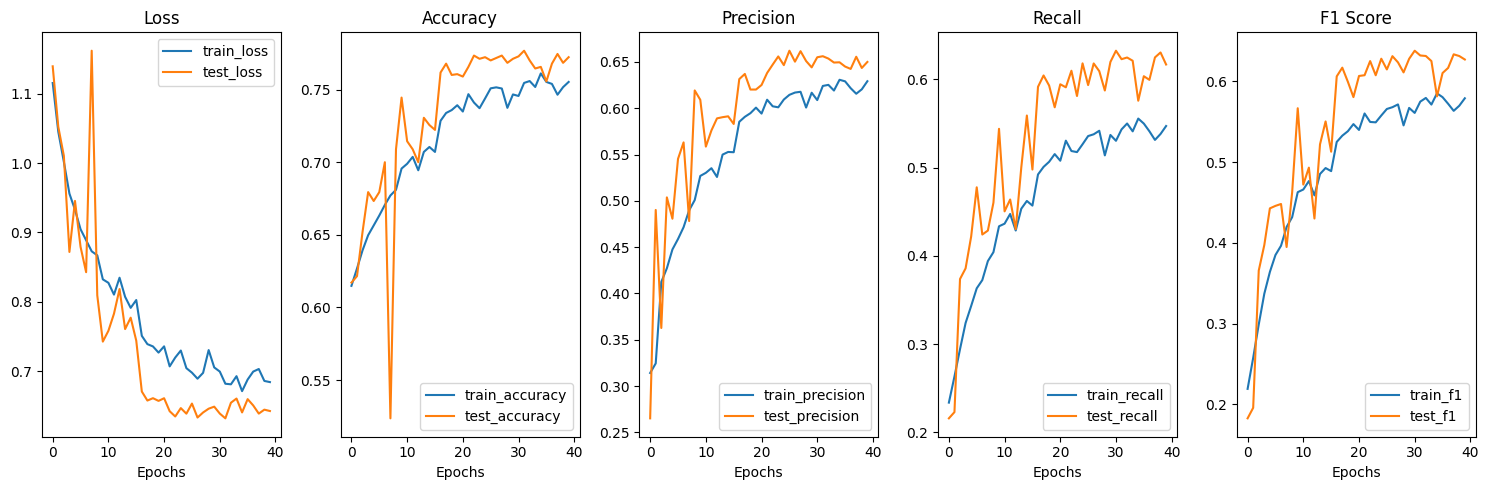

In [25]:
plot_loss_curves(results)

In [26]:
def calculate_average_results(results):
    # Calculate averages
    avg_train_loss = sum(results['train_loss']) / len(results['train_loss'])
    avg_test_loss = sum(results['test_loss']) / len(results['test_loss'])
    avg_train_precision = sum(results['train_precision']) / len(results['train_precision'])
    avg_test_precision = sum(results['test_precision']) / len(results['test_precision'])
    avg_train_recall = sum(results['train_recall']) / len(results['train_recall'])
    avg_test_recall = sum(results['test_recall']) / len(results['test_recall'])
    avg_train_f1 = sum(results['train_f1']) / len(results['train_f1'])
    avg_test_f1 = sum(results['test_f1']) / len(results['test_f1'])
    avg_train_accuracy = sum(results['train_acc']) / len(results['train_acc'])
    avg_test_accuracy = sum(results['test_acc']) / len(results['test_acc'])

    # Print average results
    print("Average Train Loss:", avg_train_loss)
    print("Average Test Loss:", avg_test_loss)
    print("Average Train Precision:", avg_train_precision)
    print("Average Test Precision:", avg_test_precision)
    print("Average Train Recall:", avg_train_recall)
    print("Average Test Recall:", avg_test_recall)
    print("Average Train F1 Score:", avg_train_f1)
    print("Average Test F1 Score:", avg_test_f1)
    print("Average Train Accuracy:", avg_train_accuracy)
    print("Average Test Accuracy:", avg_test_accuracy)

# Assuming 'results' is your dictionary containing the results
calculate_average_results(results)


Average Train Loss: 0.7811257538705946
Average Test Loss: 0.741195562549463
Average Train Precision: tensor(0.5574, device='cuda:0')
Average Test Precision: tensor(0.5974, device='cuda:0')
Average Train Recall: tensor(0.4705, device='cuda:0')
Average Test Recall: tensor(0.5346, device='cuda:0')
Average Train F1 Score: tensor(0.4975, device='cuda:0')
Average Test F1 Score: tensor(0.5425, device='cuda:0')
Average Train Accuracy: tensor(0.7177, device='cuda:0')
Average Test Accuracy: tensor(0.7335, device='cuda:0')


In [27]:
"""
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# cutout ve cutmix fonksiyonlarınızın buraya dahil edildiğini varsayıyoruz
# cutout, cutmix, rand_bbox fonksiyonlarını içe aktarın

def visualize_cutout_and_cutmix_from_dataloader(dataloader, device, length=16, alpha=1.0):
    # DataLoader'dan bir batch veri çek
    dataiter = iter(dataloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    # İlk görüntü üzerinde cutout ve cutmix işlemlerini uygula
    original_img = images[0].clone()
    cutout_img = cutout(images[0].unsqueeze(0).clone(), length=length).squeeze(0)
    cutmix_img, _ = cutmix(images[0].unsqueeze(0).clone(), images[1].unsqueeze(0).clone(), alpha=alpha)
    cutmix_img = cutmix_img.squeeze(0)

    # Görüntülerin Tensor formatından numpy formatına dönüştürülmesi
    original_img_np = original_img.permute(1, 2, 0).cpu().numpy()
    cutout_img_np = cutout_img.permute(1, 2, 0).cpu().numpy()
    cutmix_img_np = cutmix_img.permute(1, 2, 0).cpu().numpy()

    # Görselleştirme
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original_img_np)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(cutout_img_np)
    axs[1].set_title("Cutout Image")
    axs[1].axis('off')

    axs[2].imshow(cutmix_img_np)
    axs[2].set_title("Cutmix Image")
    axs[2].axis('off')

    plt.show()

# Device belirle
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Görselleştirme fonksiyonunu çağır
visualize_cutout_and_cutmix_from_dataloader(train_dataloader_custom, device)

"""

'\nimport torch\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport random\n\n# cutout ve cutmix fonksiyonlarınızın buraya dahil edildiğini varsayıyoruz\n# cutout, cutmix, rand_bbox fonksiyonlarını içe aktarın\n\ndef visualize_cutout_and_cutmix_from_dataloader(dataloader, device, length=16, alpha=1.0):\n    # DataLoader\'dan bir batch veri çek\n    dataiter = iter(dataloader)\n    images, labels = next(dataiter)\n    images, labels = images.to(device), labels.to(device)\n\n    # İlk görüntü üzerinde cutout ve cutmix işlemlerini uygula\n    original_img = images[0].clone()\n    cutout_img = cutout(images[0].unsqueeze(0).clone(), length=length).squeeze(0)\n    cutmix_img, _ = cutmix(images[0].unsqueeze(0).clone(), images[1].unsqueeze(0).clone(), alpha=alpha)\n    cutmix_img = cutmix_img.squeeze(0)\n\n    # Görüntülerin Tensor formatından numpy formatına dönüştürülmesi\n    original_img_np = original_img.permute(1, 2, 0).cpu().numpy()\n    cutout_img_np = cutout_img.permute(1, 2,